In [1]:
import numpy as np
import pandas as pd

from pyinform.dist import Dist
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import entropy

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.stattools import pacf 
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mutual_info_score

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

### $AR(1)$ 
#### $S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$

In [14]:
np.random.seed(42)

ar = np.array([1, -0.1]) # AR Order=1, PHI=0.9 (MOMENTUM)
ma = np.array([1])

process = ArmaProcess(ar, ma)
series = process.generate_sample(1000, )

In [5]:
print(f'mu: {np.mean(series)}')
print(f'sigma: {np.std(series)}')
print(f'sigma2: {np.var(series)}')

mu: 0.021421880675430712
sigma: 0.9829272439271003
sigma2: 0.9661459668541253


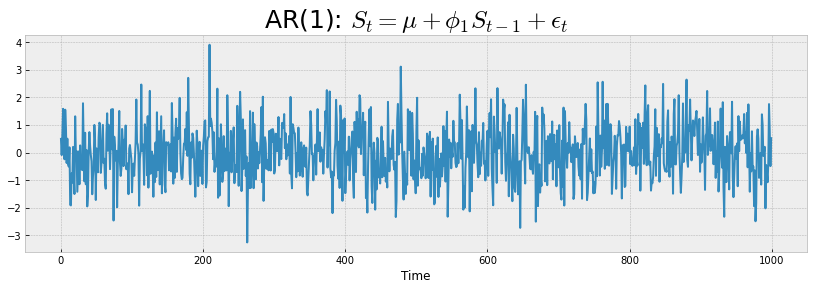

In [6]:
plt.figure(figsize=(14,4))
plt.title('AR(1): '+'$S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$', fontsize=25)
plt.plot(series)
plt.xlabel('Time')
plt.show()

In [7]:
data = pd.DataFrame({'ar':series})
s_dict = {}
n_series = 6
for s in range(n_series):
    idx = s
    name = 'l'+str(idx)
    s_dict[name] = idx
    data[name] = data['ar'].shift(idx)
data.head()

,ar,l0,l1,l2,l3,l4,l5
0,0.496714,0.496714,NaN,NaN,NaN,NaN,NaN
1,-0.088593,-0.088593,0.496714,NaN,NaN,NaN,NaN
2,0.638829,0.638829,-0.088593,0.496714,NaN,NaN,NaN
3,1.586913,1.586913,0.638829,-0.088593,0.496714,NaN,NaN
4,-0.075462,-0.075462,1.586913,0.638829,-0.088593,0.496714,NaN


In [8]:
data.corr()

,ar,l0,l1,l2,l3,l4,l5
ar,1.000000,1.000000,0.092669,0.010155,0.011908,-0.050156,0.022198
l0,1.000000,1.000000,0.092669,0.010155,0.011908,-0.050156,0.022198
l1,0.092669,0.092669,1.000000,0.092960,0.009745,0.011020,-0.049953
l2,0.010155,0.010155,0.092960,1.000000,0.093423,0.010683,0.010807
l3,0.011908,0.011908,0.009745,0.093423,1.000000,0.092163,0.011024
l4,-0.050156,-0.050156,0.011020,0.010683,0.092163,1.000000,0.093054
l5,0.022198,0.022198,-0.049953,0.010807,0.011024,0.093054,1.000000


In [9]:
y_series = 'l4'

x = data['ar'].values
y = data[y_series].values

x = x[s_dict[y_series]:]
y = y[s_dict[y_series]:]

In [10]:
state_set = np.arange(4, 31, 5) #number of bins for MI
state_set

array([ 4,  9, 14, 19, 24, 29])

In [11]:
states = 10

big_correlations = []
big_informations = []

for states in state_set:
    correlations = []
    informations = []
    print(f'States={states}','='*100)
    for serie in s_dict.keys():
        #print(f'Serie: {states}')
        x = data['ar'].values
        y = data[serie].values

        x = x[s_dict[serie]:]
        y = y[s_dict[serie]:]

        pxy, xbin, ybin = np.histogram2d(x, y, bins=states)
        joint = pxy/pxy.sum()
        qX = joint.sum(1)
        qY = joint.sum(0)

        hX = entropy(qX, base=2)
        hY = entropy(qY, base=2)

        pX_Y = joint / qY

        hX_Y =  np.sum(qY * np.log2(np.e) * np.apply_along_axis(entropy, 0, pX_Y))

        miXY = hX - hX_Y

        correlations.append(np.corrcoef(x, y)[0,1])
        informations.append(miXY)

        #print(f'Corr: {np.corrcoef(x, y)[0,1]:.3f}')
        #print(f'H(X): {hX:.3f} bits')
        #print(f'H(Y): {hY:.3f} bits')
        #print(f'I(X:Y): {miXY:.3f} bits | Reduction in the description of X')
        print(f'Reduction (lag={serie}): {miXY / hX :.3f}%')
        #print('')
    big_correlations.append(correlations)
    big_informations.append(informations)

States=4 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.006%
Reduction (lag=l2): 0.005%
Reduction (lag=l3): 0.003%
Reduction (lag=l4): 0.005%
Reduction (lag=l5): 0.005%
States=9 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.016%
Reduction (lag=l2): 0.018%
Reduction (lag=l3): 0.016%
Reduction (lag=l4): 0.019%
Reduction (lag=l5): 0.023%
States=14 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.034%
Reduction (lag=l2): 0.024%
Reduction (lag=l3): 0.032%
Reduction (lag=l4): 0.033%
Reduction (lag=l5): 0.025%
States=19 ====================================================================================================
Reduction (lag=l0): nan%
Reduction (lag=l1): nan%
Reduction (lag=l2): na

<ipython-input-11-88106c4aca8c>:26: RuntimeWarning: invalid value encountered in divide
  pX_Y = joint / qY


In [12]:
summary = pd.DataFrame({'signal':[0,1,2,3,4,5],
                     'corr':correlations})
for idx, mi in zip(state_set, big_informations):
    name = 'mi_'+str(idx)
    #print(name)
    summary[name] = mi
summary

,signal,corr,mi_4,mi_9,mi_14,mi_19,mi_24,mi_29
0,0,1.000000,1.354183,2.384564,2.995101,NaN,NaN,NaN
1,1,0.092669,0.008417,0.037252,0.101479,NaN,NaN,NaN
2,2,0.010155,0.007174,0.042541,0.072623,NaN,NaN,NaN
3,3,0.011908,0.003953,0.038550,0.095659,NaN,NaN,NaN
4,4,-0.050156,0.006141,0.045897,0.098619,NaN,NaN,NaN
5,5,0.022198,0.006457,0.055776,0.075612,NaN,NaN,NaN


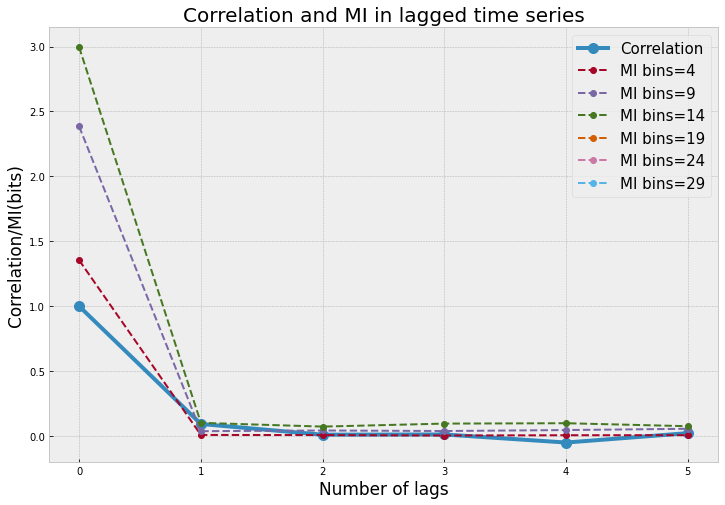

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Correlation and MI in lagged time series', fontsize=20)
ax.plot(summary['signal'], 
        summary['corr'],
        linewidth=4, 
        marker = 'o',
        markersize=10,
        label='Correlation')
for s in summary.columns[2:]:
    ax.plot(summary['signal'], summary[s], linestyle='--', marker = 'o', label=f'MI bins={s[3:]}')

ax.set_xticks(summary.signal)
plt.legend(fontsize=15)
plt.xlabel('Number of lags', fontsize=17)
plt.ylabel('Correlation/MI(bits)', fontsize=17)
plt.show()